In [456]:


from dotenv import load_dotenv
import os, getpass
from langchain_groq import ChatGroq
from langchain_unstructured import UnstructuredLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition 
import langsmith
import os
import getpass
from dotenv import load_dotenv
from langchain_groq import ChatGroq


# Load environment variables from the .env file
load_dotenv()

# Ensure environment variables are set
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please set {var}: ")



# Debug: Print out the environment variables to ensure they're loaded correctly
print(f"LANGCHAIN_API_KEY: {os.getenv('LANGCHAIN_API_KEY')}")
print(f"LANGSMITH_API_KEY: {os.getenv('LANGSMITH_API_KEY')}")
print(f"LANGSMITH_PROJECT: {os.getenv('LANGSMITH_PROJECT')}")
print(f"tracing: {os.getenv('LANGCHAIN_TRACING_V2')}")


# Initialize the LLM (make sure this is correct and that Groq model supports LangSmith tracing)
llm = ChatGroq(api_key="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", model="mistral-saba-24b")



LANGCHAIN_API_KEY: None
LANGSMITH_API_KEY: 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
LANGSMITH_PROJECT: pr-prickly-rush-65
tracing: true


In [438]:
import operator
from langgraph.graph import MessagesState
from typing import Annotated
from typing import List

class State(MessagesState):
    query:str
    subqueries: str
    human_feedback_full: str
    retrieval_content:Annotated[list, operator.add]
    subquery:str
    pdf_path: str
    pdf:Annotated[List[str],operator.add]
    chunks:Annotated[List[str],operator.add]
    query_summary:str

   
    



In [439]:
from langgraph.constants import Send
def query_expander(state:State):
    
    user_query = state['query']

    human_feedback = state.get('human_feedback_full', "")
    QUERY_REWRITE_FORMAT = """You are an AI assistant tasked with reformulating user queries to improve retrieval in a RAG system. 
    Given the original query, rewrite it to be more specific, detailed, and likely to retrieve relevant information. Give me 2-3 new quiries. Furthermore, you may be
    supplied with user feeback and if so you need to take this into account to 
    generate queries to the need of the user

    Original query: {original_query}

    Human Feedback: {human_feedback_full}

    Rewritten query:"""
#system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    if user_query:
        query_rewrite_prompt = QUERY_REWRITE_FORMAT.format(original_query=user_query, human_feedback_full=human_feedback)
        subqueries = llm.invoke(query_rewrite_prompt)
        subqueries = subqueries.content
    else:
        raise ValueError("Error: Something went wrong")


    return {'subqueries':subqueries}

def human_feedback(state: State) -> dict:
    human_answer = input("Please provide feedback on the query reformulation (type yes if you are fine with everything): ")

    if human_answer != 'yes':
        return {"next_node": "query_expander"}  # ✅ Return a dictionary
    else:
        return {"next_node": "tavily_search"}  # ✅ Return a dictionary
    
def decide_next_node(state: dict) -> str:
    """Determines the next node based on the 'next_node' key in the state."""
    return state.get('next_node', '')

In [440]:
# from IPython.display import Image, display
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph import StateGraph, START

# workflow = StateGraph(State)
# workflow.add_node("query_expander", query_expander)
# workflow.add_node("human_feedback", human_feedback)
# workflow.add_edge(START, "query_expander")
# workflow.add_edge("query_expander", "human_feedback")
# workflow.add_conditional_edges("human_feedback", should_continue,["query_expander",END])    

# memory = MemorySaver()
# graph=workflow.compile(interrupt_before=['human_feedback'], checkpointer=memory)
# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [441]:
# from langchain_core.prompts.chat import HumanMessage
# initial_input = 'How does machine learning work? Do machines actually learn like humans?'


# # Thread
# thread = {"configurable": {"thread_id": "1"}}

# for event in graph.stream({"query":initial_input}, thread, stream_mode="values"):
#     print(event)




In [442]:
# state = graph.get_state(thread)
# state.next

In [443]:
# # We now update the state as if we are the human_feedback node
# graph.update_state(thread, {"human_feedback_full": 
#                             "Make the queries more general such that a fifth grader can understand the question"}, as_node="human_feedback")

In [444]:
# for event in graph.stream(None, thread, stream_mode="values"):
#     print(event['subqueries'])

In [445]:
# from typing import List, Optional
# from langchain.vectorstores import Chroma

# class InfoState(MessagesState):
#     retrieval_content:Annotated[list, operator.add]
#     subquery:str
#     pdf_path: str
#     pdf:Annotated[List[str],operator.add]
#     chunks:Annotated[List[str],operator.add]
#     query_summary:str



In [446]:
from langchain_community.tools.tavily_search import TavilySearchResults



def tavily_search(state:State):
    subquery = state.get('subqueries', ["Are LLMS EVIL?"])

    

    TAVILY_SEARCH_PROMPT = """You are given the following query:
                              {query}
                              Your job is to obtain the best information to answer the set of 
                              questions"""
    TAVILY_API_KEY= os.getenv('TAVILY_API_KEY')

    tavily_query_rewrite = TAVILY_SEARCH_PROMPT.format(query=subquery)


    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY)
    search_results = tavily_search.invoke(tavily_query_rewrite)



    return {"retrieval_content":[search_results]}




In [447]:
from langchain.document_loaders import PyMuPDFLoader
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


def pdf_loader(state:State):
    pdf_path = state.get("pdf_path",'how__llms__work.pdf')
    pdf_loader = PyMuPDFLoader(pdf_path)
    pdf_pages=[]
    # Extract documents (text)
    documents = pdf_loader.load()
    for doc in documents:
        state['pdf'].append(doc.page_content)  # appending the extracted text to the 'pdf' key in the state
    
    # Returning the updated state
    return {'pdf': state['pdf']}

def split_text(state:State):
    documents = [Document(page_content=text) for text in state['pdf']]
    
    # Initialize the text splitter
    splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n"],
        chunk_size=10000,
        chunk_overlap=500
    )
    
    # Split the documents into chunks
    chunks = splitter.split_documents(documents)
    
    # Append the chunks to the state['chunks'] list
    for chunk in chunks:
        state['chunks'].append(chunk)
    # Returning the updated state
    return {'chunks': state['chunks']}

def build_vector_store_retrieval(state: State):
    chunks = state.get('chunks', [])  # Use .get() to avoid KeyError if 'chunks' is missing

    # Ensure chunks is a list of Document objects
    documents = [Document(page_content=str(chunk)) for chunk in chunks]

    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    vector_store = Chroma.from_documents(documents, embedding=embeddings)

    query = state.get('subqueries', '')  # Avoid KeyError if 'subquery' is missing

    search_results = vector_store.similarity_search(query, k=3)

    retrieved_content = [doc.page_content for doc in search_results]

    return {'retrieval_content': retrieved_content}

In [448]:

def summary(state: State):
    all_retrieved_info = state['retrieval_content']
    subqueries = state['subqueries']
    formatted_retrieved_content = "\n".join([doc.page_content if isinstance(doc, Document) else str(doc) for doc in all_retrieved_info])
    summary_prompt = f"""
    You are an AI assistant tasked with summarizing the following retrieved information:

    {formatted_retrieved_content}

    Provide a concise and informative summary of the content given the queries: {subqueries}
    """

    response = llm.invoke(summary_prompt)



    return {'query_summary': response}
    
  


In [449]:
# builder = StateGraph(InfoState)
# builder.add_node('tavily_search', tavily_search)
# builder.add_node('pdf_loader', pdf_loader)
# builder.add_node('split_text', split_text)
# builder.add_node('build_vector_store_retrieval', build_vector_store_retrieval)
# builder.add_node('summary', summary)

# # Add edges to define the flow of the graph
# builder.add_edge(START, 'tavily_search')
# builder.add_edge('tavily_search', 'pdf_loader')
# builder.add_edge('pdf_loader', 'split_text')
# builder.add_edge('split_text', 'build_vector_store_retrieval')
# builder.add_edge('build_vector_store_retrieval', 'summary')
# builder.add_edge('summary', END)

# # Compile the graph
# memory = MemorySaver()
# interview_graph = builder.compile(checkpointer=memory).with_config(run_name="Conduct Retrieval")

# # View the graph (if you want to visualize it)
# display(Image(interview_graph.get_graph().draw_mermaid_png()))




In [450]:
# state_input = {
#     'subquery': 'How does Natural language processing work? Do machines actually learn like humans?',
#     'pdf_path': "./how__llms__work.pdf",

# }
# thread = {"configurable": {"thread_id": "1"}}
# # Run the graph with the state_input
# result = interview_graph.invoke(state_input,thread)

# # The result will contain the output from the final node in the graph (e.g., 'summary')
# print(result['query_summary'].content)


In [451]:
# class FinalState(MessagesState):
#     final_composed_summary:Annotated[List[str],operator.add]
#     summary:str
#     human_feedback_full:str
#     subqueries: Annotated[List[str], operator.add]
#     pdf_path:str


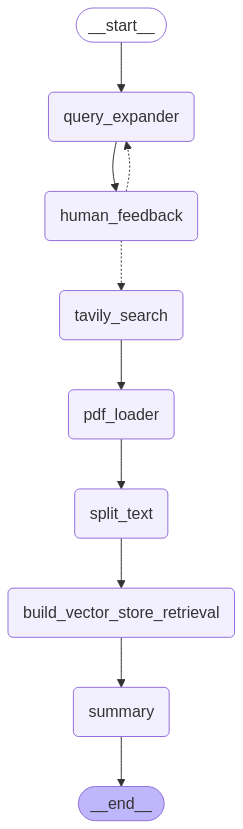

In [452]:
from langgraph.constants import Send
from langgraph.constants import START, END
from IPython.display import Image



builder = StateGraph(State)

builder.add_node('query_expander', query_expander)
builder.add_node('human_feedback', human_feedback)
builder.add_node('tavily_search', tavily_search)
builder.add_node('pdf_loader', pdf_loader)
builder.add_node('split_text', split_text)
builder.add_node('build_vector_store_retrieval', build_vector_store_retrieval)
builder.add_node('summary', summary)

builder.add_edge(START,'query_expander')
builder.add_edge('query_expander','human_feedback')

builder.add_conditional_edges(
    "human_feedback",
    decide_next_node,   # Reference the function here — no need to define it as a node!
    ["query_expander", "tavily_search"])
builder.add_edge("tavily_search",'pdf_loader')
builder.add_edge("pdf_loader",'split_text')
builder.add_edge("split_text",'build_vector_store_retrieval')
builder.add_edge("build_vector_store_retrieval",'summary')
builder.add_edge("summary",END)


memory = MemorySaver()
compiled_builder = builder.compile(checkpointer=memory)

# Display the graph (optional)
display(Image(compiled_builder.get_graph(xray=1).draw_mermaid_png()))


In [453]:
query = {'query':'What is a Large Language Model (LLM), and how does it work?',}

thread = {"configurable": {"thread_id": "1"}}


for event in compiled_builder.stream(query,thread):
    
    print(event)

{'query_expander': {'subqueries': '1. "Can you explain the technology and functionality behind a Large Language Model (LLM), including its architecture, training process, and application areas?"\n2. "What are the key components and workings of a Large Language Model (LLM)? Please include details about data processing, model size, and generation of human-like text."\n3. "Considering my interest in AI, provide an in-depth explanation of Large Language Models (LLMs), focusing on their design, operation, and use cases, as well as their limitations and future potential."'}}
{'human_feedback': None}
{'tavily_search': {'retrieval_content': ["HTTPError('400 Client Error: Bad Request for url: https://api.tavily.com/search')"]}}
{'pdf_loader': {'pdf': ['A Comprehensive Overview of Large Language Models\nHumza Naveeda, Asad Ullah Khanb,∗, Shi Qiuc,∗, Muhammad Saqibd,e,∗, Saeed Anwarf,g, Muhammad Usmanf,g, Naveed Akhtarh,j,\nNick Barnesi, Ajmal Mianj\naThe University of Sydney, Sydney, Australia\n

In [454]:
# from langchain_community.tools.tavily_search import TavilySearchResults

# TAVILY_API_KEY= os.getenv('TAVILY_API_KEY')


# tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY)

# search_results = tavily_search.invoke("latest AI trends")

# contents = [result['content'] for result in search_results]
# print(contents)



In [455]:
# from langchain.document_loaders import PyMuPDFLoader
# from langchain.schema import Document

# # Load the PDF file
# pdf_loader = PyMuPDFLoader("./how_llms_work.pdf")
# pdf_list = []
# # Extract documents (text)
# documents = pdf_loader.load()
# print(documents)
# # Print extracted text
# for doc in documents:
#     pdf_list.append(doc.page_content)

# splitter = RecursiveCharacterTextSplitter(
#     separators=["\n\n", "\n"],
#     chunk_size=1000,
#     chunk_overlap=100
# )

# splits = splitter.split_documents(documents)

# # # Print each chunk's content
# # for idx, doc in enumerate(splits):
# #     print(f"Chunk {idx + 1}:")
# #     print(doc.page_content)  # This will print the text of each chunk
# #     print("-" * 50)  # Separator between chunks

# documents12 = [Document(page_content=text) for text in pdf_list]
# print(documents12)